In [1]:
def get_environment():
    try:
        # Check if the environment is Google Colab
        import google.colab
        return "colab"
    except ImportError:
        # Environment is not Google Colab, assume it is local
        return "local"

environment = get_environment()

if environment == "colab":
    colab_path = "/content/drive/MyDrive/Colab Notebooks/"
    from google.colab import drive
    drive.mount('/content/drive')
    !pip install finance-datareader
elif environment == "local":
    colab_path = ""

In [2]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from scipy import stats
from scipy.optimize import minimize

import FinanceDataReader as fdr
from datetime import timedelta

# Neural Network library
import tensorflow as tf
import tensorflow_probability as tfp

from tensorflow import keras
from tensorflow.python.keras.models import load_model
from keras import callbacks
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.layers import Activation
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.regularizers import l2

import matplotlib.pyplot as plt
plt.style.use("bmh")

# 한글 폰트 사용을 위해서 세팅
from matplotlib import font_manager, rc
plt.rc('font', family='NanumGothic') # For Windows
%matplotlib inline

MV 모델 벤치마크

In [74]:
def calc_portfolio_std(weights, mean_returns, cov):
    portfolio_std = np.sqrt(np.dot(weights.T, np.dot(cov, weights)))
    return portfolio_std

def calc_neg_sharpe(weights, mean_returns, cov, rf):
    portfolio_return = np.sum(mean_returns * weights)
    portfolio_std = np.sqrt(np.dot(weights.T, np.dot(cov, weights)))
    sharpe_ratio = (portfolio_return - rf) / portfolio_std
    return -sharpe_ratio

def calc_portfolio_VaR(weights, mean_returns, cov, alpha):
    portfolio_return = np.sum(mean_returns * weights)
    portfolio_std = np.sqrt(np.dot(weights.T, np.dot(cov, weights)))
    portfolio_var = abs(portfolio_return - (portfolio_std * stats.norm.ppf(1 - alpha)))
    return portfolio_var

def portfolio_optimization_std(w, r, cov):
    constraints = [{'type': 'eq', 'fun': lambda x: np.sum(x) - 1}]
    args = (r, cov)
    bound = (0.0, 1.0)
    bounds = tuple(bound for asset in range(len(w)))
    optimization_result = minimize(calc_portfolio_std, w, args=args, method='SLSQP', bounds=bounds, constraints=constraints)
    
    return optimization_result

def portfolio_optimization_sharpe(w, r, cov, rf):
    constraints = [{'type': 'eq', 'fun': lambda x: np.sum(x) - 1}]
    args = (r, cov, rf)
    bound = (0.0, 1.0)
    bounds = tuple(bound for asset in range(len(w)))
    optimization_result = minimize(calc_neg_sharpe, w, args=args, method='SLSQP', bounds=bounds, constraints=constraints)
    
    return optimization_result

def portfolio_optimization_Var(w, r, cov, alpha):
    constraints = [{'type': 'eq', 'fun': lambda x: np.sum(x) - 1}]
    args = (r, cov, alpha)
    bound = (0.0, 1.0)
    bounds = tuple(bound for asset in range(len(w)))
    optimization_result = minimize(calc_portfolio_VaR, w, args=args, method='SLSQP', bounds=bounds, constraints=constraints)
    
    return optimization_result

## 2018~2022 백테스트

In [171]:
df = pd.read_csv(colab_path + "top50-Stock_LogReturn.csv", index_col="Date")
train, test = train_test_split(df, test_size=0.2, shuffle=False)

train_len = len(train)
test_len = len(test)
validation_set_len = 80
validation_set_split_point = 60

xc_train = np.empty((train_len - validation_set_len, 60, 50))
xf_train = np.empty((train_len - validation_set_len, 20, 50))
xc_test = np.empty((test_len - validation_set_len, 60, 50))
xf_test = np.empty((test_len - validation_set_len, 20, 50))

for idx in range(train_len - validation_set_len):
    temp_xc_train = train[idx : idx + validation_set_split_point]
    temp_xf_train = train[idx + validation_set_split_point : idx + validation_set_len]

    xc_train[idx] = temp_xc_train
    xf_train[idx] = temp_xf_train

for idx in range(test_len - validation_set_len):
    temp_xc_test = test[idx : idx + validation_set_split_point]
    temp_xf_test = test[idx + validation_set_split_point : idx + validation_set_len]

    xc_test[idx] = temp_xc_test
    xf_test[idx] = temp_xf_test
    
# 월간 수익률 정도의 스케일로 변환한다
xc_train = xc_train.astype('float32') * 20
xf_train = xf_train.astype('float32') * 20
xc_test = xc_test.astype('float32') * 20
xf_test = xf_test.astype('float32') * 20

N_TIME = xc_train.shape[1]
N_FUTURE = xf_train.shape[1]
N_STOCKS = xf_train.shape[2]

# 학습 데이터는 shuffling 한다.
xc_train, xf_train = shuffle(xc_train, xf_train)

누적 수익률 비교

In [172]:
N_TIME = xc_test.shape[1]
N_FUTURE = xf_test.shape[1]
N_STOCKS = xf_test.shape[2]

# 저장된 Markowitz 모델을 가져온다.
SAVE_MODEL = 'Markowitz_network_final.h5'
model = load_model(SAVE_MODEL, compile = False)
model.summary()

# 백 테스트를 수행한다.
prt_value = [10000]   # portfolio의 초기 value
crp_value = [10000]   # CRP의 초기 value
mvstd_value = [10000]    # MV_std의 초기 value
mvshp_value = [10000] # MV_sharpe의 초기 value
mvVaR_value = [10000]
w_crp = np.ones(N_STOCKS) / N_STOCKS   # CRP 비율 (균등 비율)

w_history = []
w_history_std = []
w_history_shp = []
w_history_VaR = []
for i in range(0, xc_test.shape[0], N_FUTURE):
   
    # 이 시점에 각 종목을 w_prt 비율대로 매수한다.
    # 학습할 때 월간 수익률로 변환했으므로, 여기서도 변환해야 한다.
    x = xc_test[i][np.newaxis,:,:] * 20
    w_prt = model.predict(x)[0]
    w_history.append(w_prt)
    
    # 추가 코드
    x_mean = np.mean(x[0], axis=0)
    x_cov = np.cov(x[0].T)
    
    result_std = portfolio_optimization_std(w_crp, x_mean, x_cov)
    w_std = np.array([round(x,3) for x in result_std['x']])
    
    result_sharpe = portfolio_optimization_sharpe(w_crp, x_mean, x_cov, 0)
    w_shp = np.array([round(x,3) for x in result_sharpe['x']])
    
    result_VaR = portfolio_optimization_sharpe(w_crp, x_mean, x_cov, 0.05)
    w_VaR = np.array([round(x,3) for x in result_VaR['x']])
    
    w_history_std.append(w_std)
    w_history_shp.append(w_shp)
    w_history_VaR.append(w_VaR)

    # 다음 기간의 누적 수익률
    m_rtn = np.sum(xf_test[i], axis = 0) / 20
 
    # 누적 수익률과 w_prt (W)로 포트폴리오의 수익률을 계산한다.
    prt_value.append(prt_value[-1] * np.exp(np.dot(w_prt, m_rtn)))
    crp_value.append(crp_value[-1] * np.exp(np.dot(w_crp, m_rtn)))
    
    mvstd_value.append(mvstd_value[-1] * np.exp(np.dot(w_std, m_rtn)))
    mvshp_value.append(mvshp_value[-1] * np.exp(np.dot(w_shp, m_rtn)))
    mvVaR_value.append(mvVaR_value[-1] * np.exp(np.dot(w_VaR, m_rtn)))

# 평가 시점의 날짜를 발췌한다.
idx = np.arange(0, xc_test.shape[0] + 20, N_FUTURE)

# 벤치마크를 위한 S&P500 정의
us500 = fdr.DataReader('US500', '2002-01-01', '2022-12-01')\
    ['Adj Close'][-993:][idx]
us500_value = us500 / us500[0] * 10000

# Markowitz 성과와 CRP 성과를 데이터 프레임에 기록해 둔다.
perf_df = pd.DataFrame({'crp':crp_value, 'markowitz':prt_value, 'MV_Std':mvstd_value, 'MV_Max_Shp':mvshp_value, 'MV_VaR':mvVaR_value,'S&P500':us500_value})

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 60, 50)]          0         
_________________________________________________________________
lstm (LSTM)                  (None, 64)                29440     
_________________________________________________________________
dense (Dense)                (None, 50)                3250      
_________________________________________________________________
activation (Activation)      (None, 50)                0         
Total params: 32,690
Trainable params: 32,690
Non-trainable params: 0
_________________________________________________________________


누적 수익률 비교

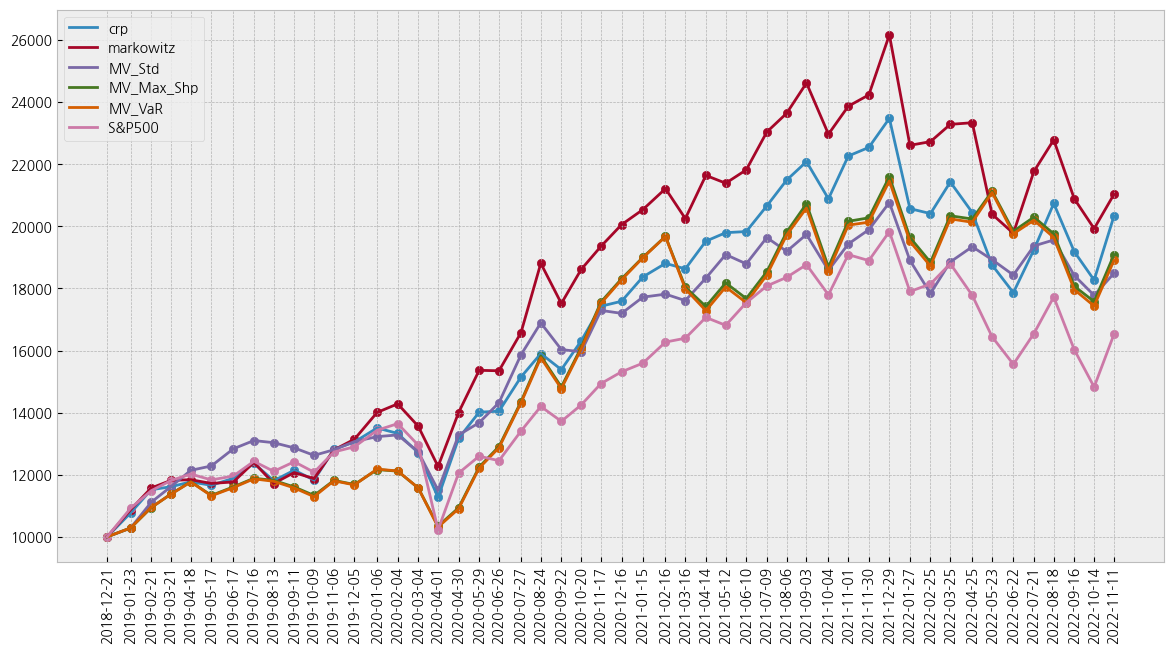

In [173]:
plt.figure(figsize=(12, 6))
plt.plot(perf_df)
plt.tight_layout()
plt.scatter(perf_df.index, perf_df['crp'])
plt.scatter(perf_df.index, perf_df['markowitz'])
plt.scatter(perf_df.index, perf_df['MV_Std'])
plt.scatter(perf_df.index, perf_df['MV_Max_Shp'])
plt.scatter(perf_df.index, perf_df['MV_VaR'])
plt.scatter(perf_df.index, perf_df['S&P500'])
plt.xticks(perf_df.index, rotation=90)
plt.legend(perf_df)

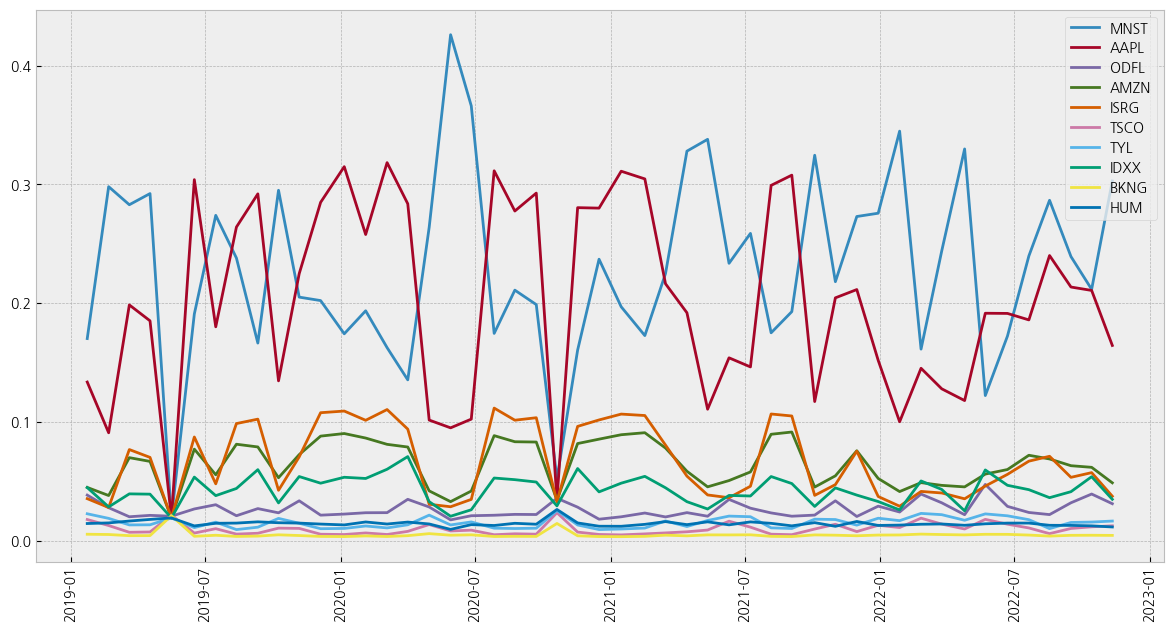

In [174]:
w_ratio = pd.DataFrame(w_history, columns=test.columns, index=perf_df.index[1:])
plt.figure(figsize=(12, 6))
plt.plot(w_ratio.iloc[:, :10])
plt.tight_layout()
plt.xticks(rotation=90)
plt.legend(w_ratio.columns[:10])

연간 평균 수익률

crp           0.178956
markowitz     0.212555
MV_Std        0.145209
MV_Max_Shp    0.187630
MV_VaR        0.186113
S&P500        0.122759
dtype: float64


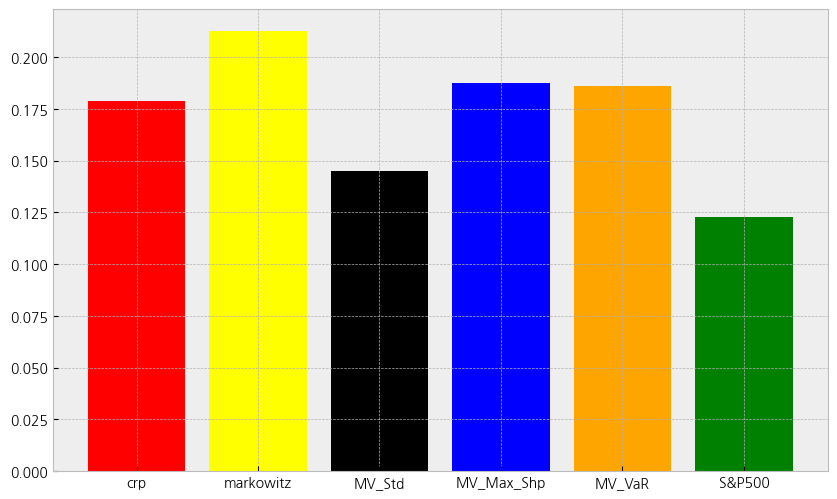

In [176]:
anual_perf = []
for i in range(len(perf_df) - 11):
    anual_perf.append(((perf_df.iloc[i+11] - perf_df.iloc[i]) / perf_df.iloc[i]))

anual_perf_df = pd.DataFrame(anual_perf)
plt.figure(figsize=(10, 6))

c = ['red', 'yellow', 'black', 'blue', 'orange', 'green']
plt.bar(x=anual_perf_df.columns, height=anual_perf_df.mean(), color=c)
print(anual_perf_df.mean())


MDD 비교

crp           23.916091
markowitz     24.431553
MV_Std        14.399943
MV_Max_Shp    18.631743
MV_VaR        18.770387
S&P500        25.244624
dtype: float64

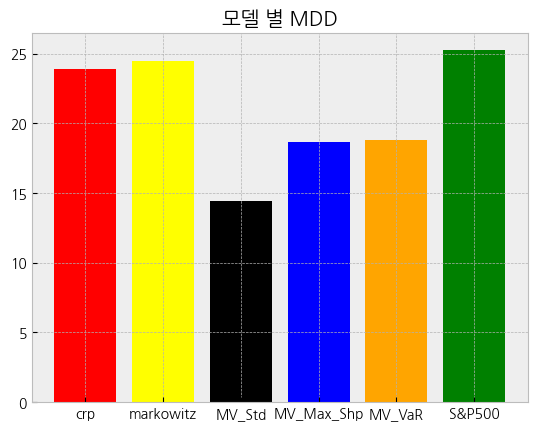

In [177]:
perf_df_mdd = perf_df.copy()
def mdd(df):
    return (df.cummax() - df) / df.cummax() * 100

temp_list = perf_df_mdd.columns
for i in temp_list:
    perf_df_mdd[i] = mdd(perf_df_mdd[i])
    
c = ['red', 'yellow', 'black', 'blue', 'orange', 'green']
plt.title('모델 별 MDD')
plt.bar(perf_df_mdd.columns, height=perf_df_mdd.max(), color=c)
perf_df_mdd.max()

Std, shp, var 비교

In [178]:
model = [[], [], []]
std = [[], [], []]
shp = [[], [], []]
var = [[], [], []]

for i in range(0, xc_test.shape[0], N_FUTURE):
    # 추가 코드
    x_mean = np.mean(x[0], axis=0)
    x_cov = np.cov(x[0].T)
    
    a = int(i/20)
    
    model[0].append(calc_portfolio_std(w_history[a], x_mean, x_cov))
    model[1].append(calc_neg_sharpe(w_history[a], x_mean, x_cov, 0))
    model[2].append(calc_portfolio_VaR(w_history[a], x_mean, x_cov, 0.05))
    
    std[0].append(calc_portfolio_std(w_history_std[a], x_mean, x_cov))
    std[1].append(calc_neg_sharpe(w_history_std[a], x_mean, x_cov, 0))
    std[2].append(calc_portfolio_VaR(w_history_std[a], x_mean, x_cov, 0.05))
    
    shp[0].append(calc_portfolio_std(w_history_shp[a], x_mean, x_cov))
    shp[1].append(calc_neg_sharpe(w_history_shp[a], x_mean, x_cov, 0))
    shp[2].append(calc_portfolio_VaR(w_history_shp[a], x_mean, x_cov, 0.05))
    
    var[0].append(calc_portfolio_std(w_history_VaR[a], x_mean, x_cov))
    var[1].append(calc_neg_sharpe(w_history_VaR[a], x_mean, x_cov, 0))
    var[2].append(calc_portfolio_VaR(w_history_VaR[a], x_mean, x_cov, 0.05))

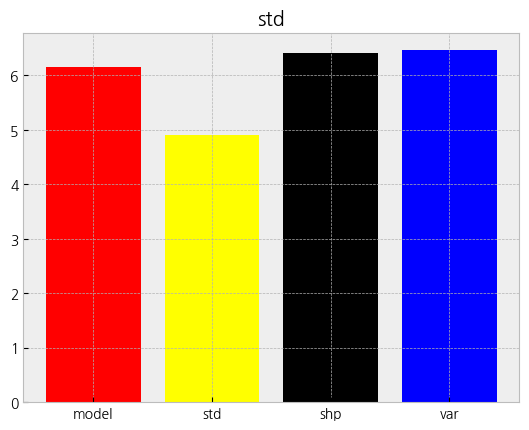

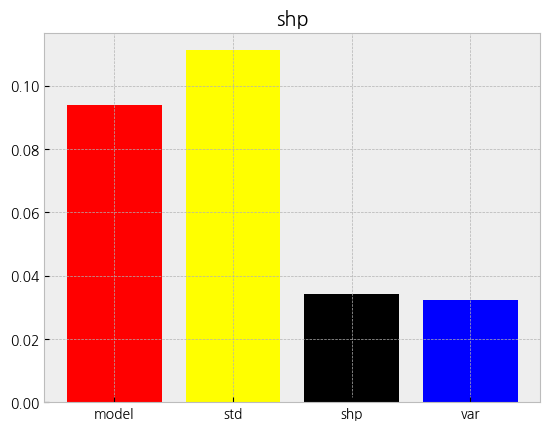

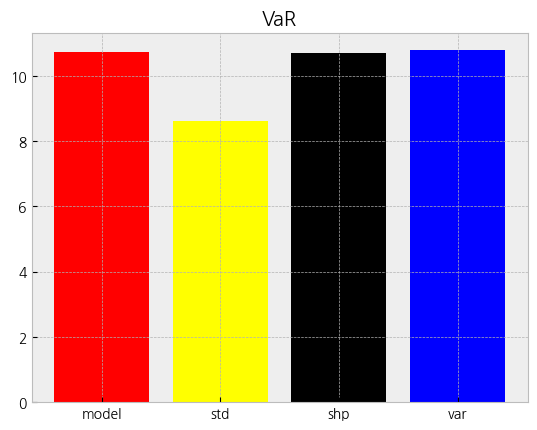

In [179]:
from statistics import mean
for i in range(0, 3):
    title = ['std', 'shp', 'VaR']
    plt.bar(x=['model', 'std', 'shp', 'var'], height=(mean(model[i]), mean(std[i]), mean(shp[i]), mean(var[i])), color=c)
    plt.title(title[i])
    plt.show()

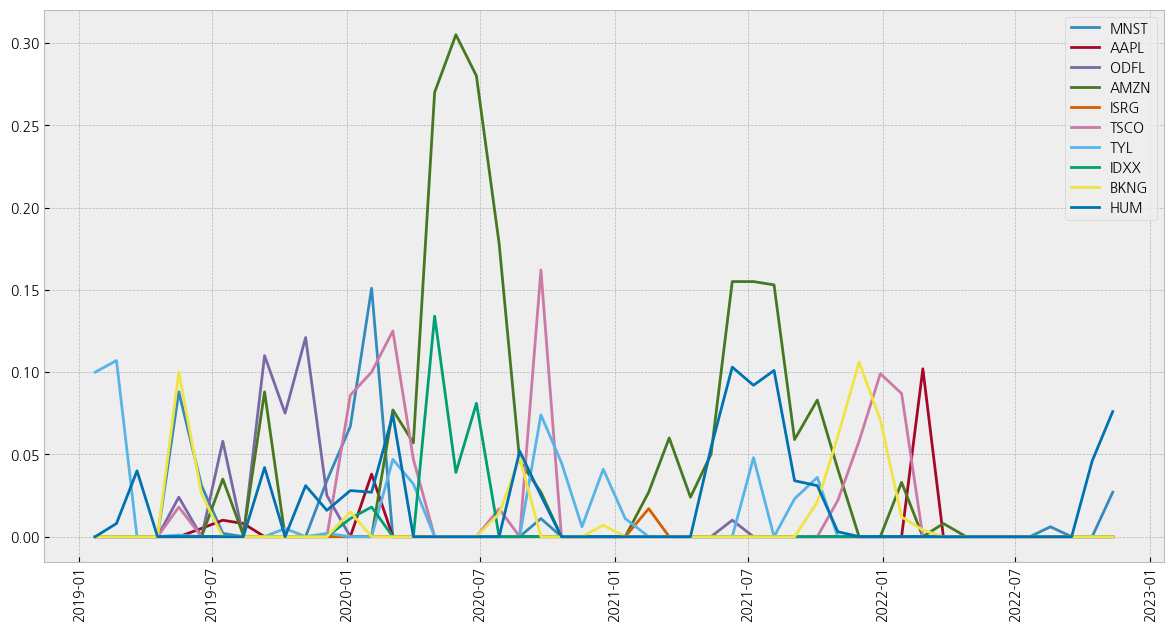

In [180]:
w_ratio = pd.DataFrame(w_history_std, columns=test.columns, index=perf_df.index[1:])
plt.figure(figsize=(12, 6))
plt.plot(w_ratio.iloc[:, :10])
plt.tight_layout()
plt.xticks(rotation=90)
plt.legend(w_ratio.columns[:10])

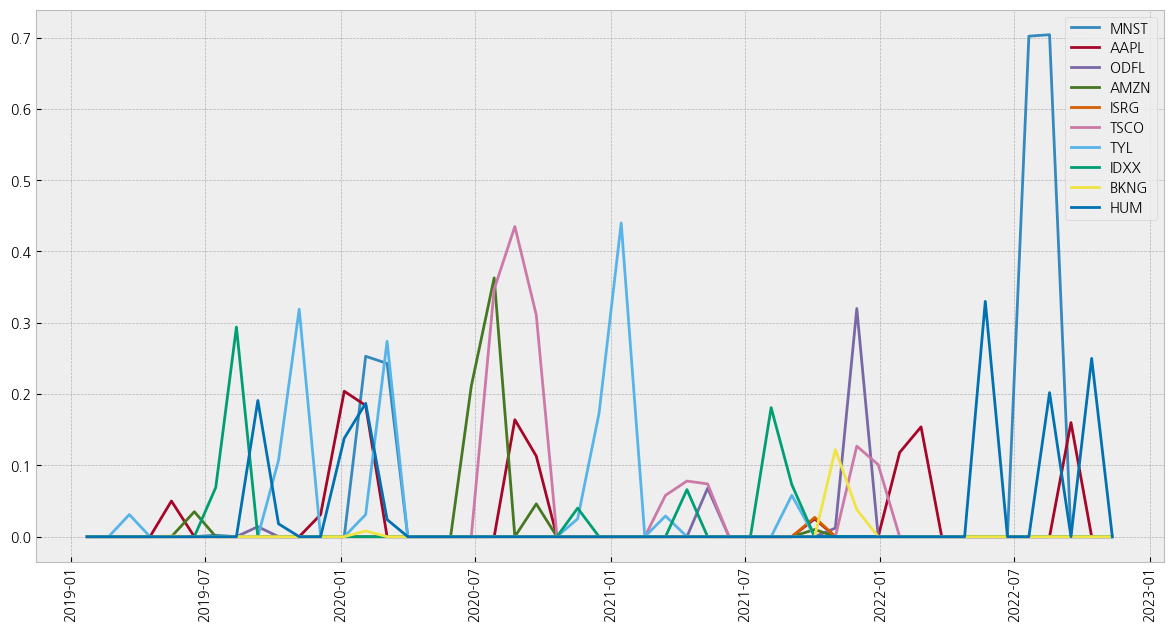

In [181]:
w_ratio = pd.DataFrame(w_history_shp, columns=test.columns, index=perf_df.index[1:])
plt.figure(figsize=(12, 6))
plt.plot(w_ratio.iloc[:, :10])
plt.tight_layout()
plt.xticks(rotation=90)
plt.legend(w_ratio.columns[:10])

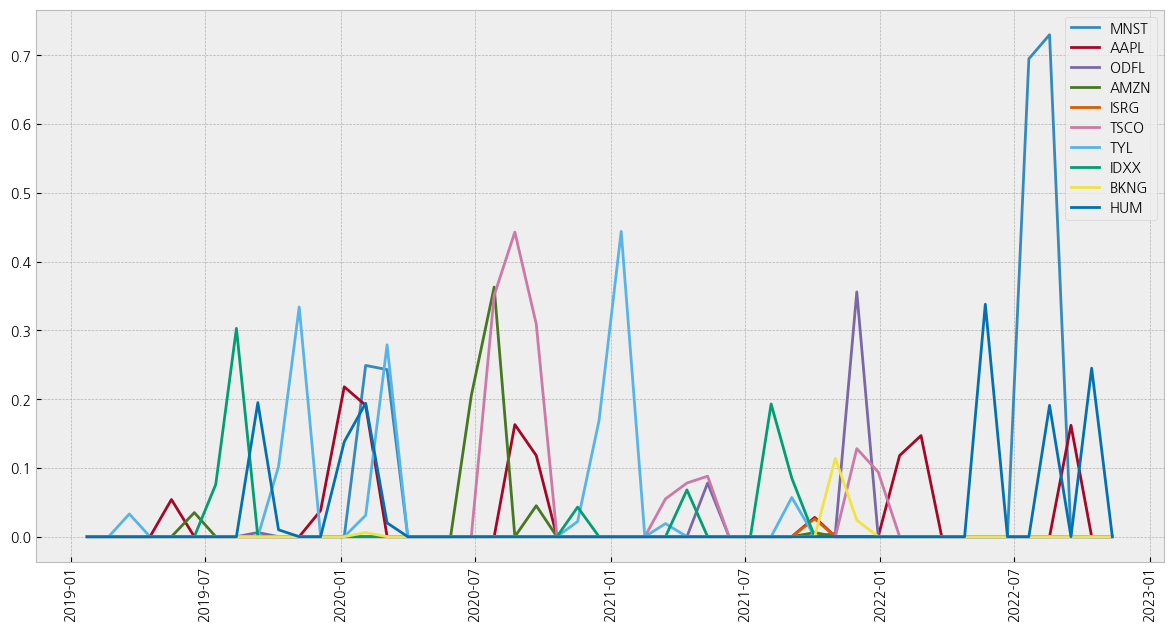

In [182]:
w_ratio = pd.DataFrame(w_history_VaR, columns=test.columns, index=perf_df.index[1:])
plt.figure(figsize=(12, 6))
plt.plot(w_ratio.iloc[:, :10])
plt.tight_layout()
plt.xticks(rotation=90)
plt.legend(w_ratio.columns[:10])

예언자(Prophet)과 벤치마킹

In [183]:
N_TIME = xc_test.shape[1]
N_FUTURE = xf_test.shape[1]
N_STOCKS = xf_test.shape[2]

# 저장된 Markowitz 모델을 가져온다.
SAVE_MODEL = 'prophet.h5'
model = load_model(SAVE_MODEL, compile = False)
model.summary()

# 백 테스트를 수행한다.
prt_value = [10000]   # portfolio의 초기 value

w_history_prophet = []
for i in range(0, xc_test.shape[0], N_FUTURE):
   
    # 이 시점에 각 종목을 w_prt 비율대로 매수한다.
    # 학습할 때 월간 수익률로 변환했으므로, 여기서도 변환해야 한다.
    x = xc_test[i][np.newaxis,:,:] * 20
    w_prt = model.predict(x)[0]
    w_history_prophet.append(w_prt)

    # 다음 기간의 누적 수익률
    m_rtn = np.sum(xf_test[i], axis = 0) / 20
 
    # 누적 수익률과 w_prt (W)로 포트폴리오의 수익률을 계산한다.
    prt_value.append(prt_value[-1] * np.exp(np.dot(w_prt, m_rtn)))

# 평가 시점의 날짜를 발췌한다.
idx = np.arange(0, xc_test.shape[0] + 20, N_FUTURE)

# 벤치마크를 위한 S&P500 정의
us500 = fdr.DataReader('US500', '2002-01-01', '2022-12-01')\
    ['Adj Close'][-993:][idx]
us500_value = us500 / us500[0] * 10000

# Markowitz 성과와 CRP 성과를 데이터 프레임에 기록해 둔다.
perf_df_prophet = pd.DataFrame({'prophet':prt_value}, index=test[-993:].index[idx])

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 60, 50)]          0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 64)                29440     
_________________________________________________________________
dense_5 (Dense)              (None, 50)                3250      
_________________________________________________________________
activation_5 (Activation)    (None, 50)                0         
Total params: 32,690
Trainable params: 32,690
Non-trainable params: 0
_________________________________________________________________


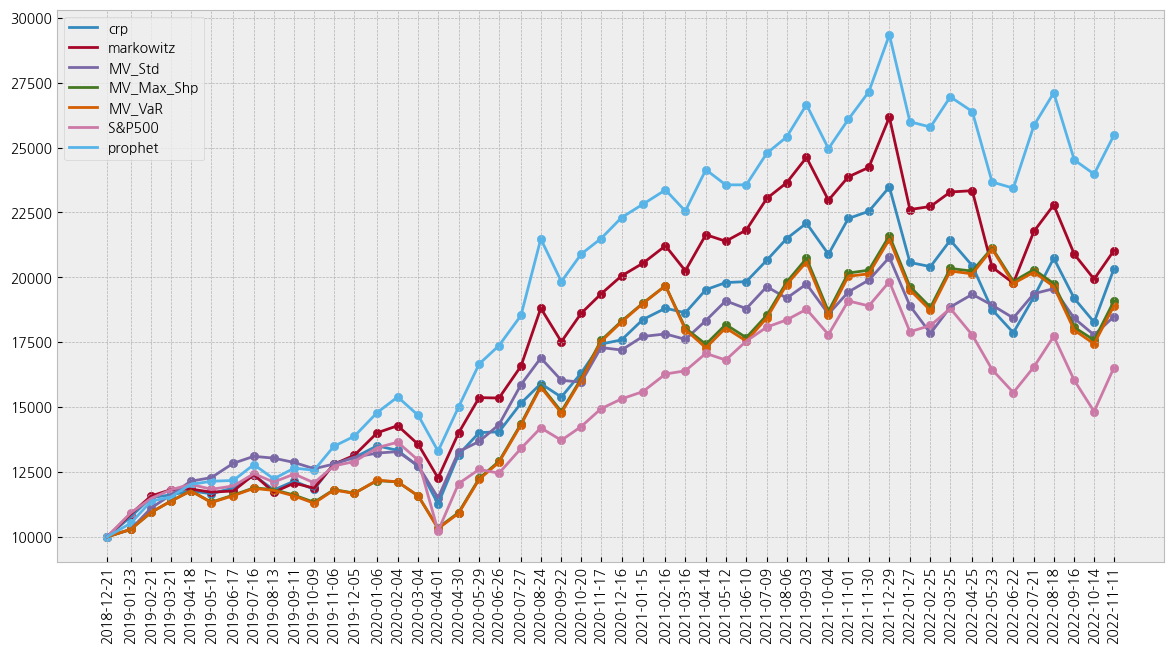

In [184]:
perf_df['prophet'] = list(perf_df_prophet['prophet'])

plt.figure(figsize=(12, 6))
plt.plot(perf_df)
plt.tight_layout()
plt.scatter(perf_df.index, perf_df['crp'])
plt.scatter(perf_df.index, perf_df['markowitz'])
plt.scatter(perf_df.index, perf_df['MV_Std'])
plt.scatter(perf_df.index, perf_df['MV_Max_Shp'])
plt.scatter(perf_df.index, perf_df['MV_VaR'])
plt.scatter(perf_df.index, perf_df['S&P500'])
plt.scatter(perf_df.index, perf_df['prophet'])
plt.xticks(perf_df.index, rotation=90)
plt.legend(perf_df)

---

In [196]:
df = pd.read_csv(colab_path + "top50-Stock_LogReturn.csv", index_col="Date")
train, test = df[1053:], df[:1053]

train_len = len(train)
test_len = len(test)
validation_set_len = 80
validation_set_split_point = 60

xc_train = np.empty((train_len - validation_set_len, 60, 50))
xf_train = np.empty((train_len - validation_set_len, 20, 50))
xc_test = np.empty((test_len - validation_set_len, 60, 50))
xf_test = np.empty((test_len - validation_set_len, 20, 50))

for idx in range(train_len - validation_set_len): # test_len 부터 뒷부분
    temp_xc_train = train[idx : idx + validation_set_split_point]
    temp_xf_train = train[idx + validation_set_split_point : idx + validation_set_len]

    xc_train[idx] = temp_xc_train
    xf_train[idx] = temp_xf_train

for idx in range(test_len - validation_set_len): # 앞부분
    temp_xc_test = test[idx : idx + validation_set_split_point]
    temp_xf_test = test[idx + validation_set_split_point : idx + validation_set_len]

    xc_test[idx] = temp_xc_test
    xf_test[idx] = temp_xf_test

In [197]:
# 월간 수익률 정도의 스케일로 변환한다
xc_train = xc_train.astype('float32') * 20
xf_train = xf_train.astype('float32') * 20
xc_test = xc_test.astype('float32') * 20
xf_test = xf_test.astype('float32') * 20

N_TIME = xc_train.shape[1]
N_FUTURE = xf_train.shape[1]
N_STOCKS = xf_train.shape[2]

# 학습 데이터는 shuffling 한다.
xc_train, xf_train = shuffle(xc_train, xf_train)

In [198]:
N_TIME = xc_test.shape[1]
N_FUTURE = xf_test.shape[1]
N_STOCKS = xf_test.shape[2]

# 저장된 Markowitz 모델을 가져온다.
SAVE_MODEL = 'Markowitz_network_CV_final.h5'
model = load_model(SAVE_MODEL, compile = False)
model.summary()

# 백 테스트를 수행한다.
prt_value = [10000]   # portfolio의 초기 value
crp_value = [10000]   # CRP의 초기 value
mvstd_value = [10000]    # MV_std의 초기 value
mvshp_value = [10000] # MV_sharpe의 초기 value
mvVaR_value = [10000] # MV_VaR의 초기 value
w_crp = np.ones(N_STOCKS) / N_STOCKS   # CRP 비율 (균등 비율)

w_history = []
w_history_std = []
w_history_shp = []
w_history_VaR = []
for i in range(0, xc_test.shape[0], N_FUTURE):
   
    # 이 시점에 각 종목을 w_prt 비율대로 매수한다.
    # 학습할 때 월간 수익률로 변환했으므로, 여기서도 변환해야 한다.
    x = xc_test[i][np.newaxis,:,:] * 20
    w_prt = model.predict(x)[0]
    w_history.append(w_prt)
    
    # 추가 코드
    x_mean = np.mean(x[0], axis=0)
    x_cov = np.cov(x[0].T)
    
    result_std = portfolio_optimization_std(w_crp, x_mean, x_cov)
    w_std = np.array([round(x,3) for x in result_std['x']])
    
    result_sharpe = portfolio_optimization_sharpe(w_crp, x_mean, x_cov, 0)
    w_shp = np.array([round(x,3) for x in result_sharpe['x']])
    
    result_VaR = portfolio_optimization_sharpe(w_crp, x_mean, x_cov, 0.05)
    w_VaR = np.array([round(x,3) for x in result_VaR['x']])
    
    w_history_std.append(w_std)
    w_history_shp.append(w_shp)
    w_history_VaR.append(w_VaR)

    # 다음 기간의 누적 수익률
    m_rtn = np.sum(xf_test[i], axis = 0) / 20
 
    # 누적 수익률과 w_prt (W)로 포트폴리오의 수익률을 계산한다.
    prt_value.append(prt_value[-1] * np.exp(np.dot(w_prt, m_rtn)))
    crp_value.append(crp_value[-1] * np.exp(np.dot(w_crp, m_rtn)))
    
    mvstd_value.append(mvstd_value[-1] * np.exp(np.dot(w_std, m_rtn)))
    mvshp_value.append(mvshp_value[-1] * np.exp(np.dot(w_shp, m_rtn)))
    mvVaR_value.append(mvVaR_value[-1] * np.exp(np.dot(w_VaR, m_rtn)))

# 평가 시점의 날짜를 발췌한다.
idx = np.arange(0, xc_test.shape[0] + 20, N_FUTURE)

# 벤치마크를 위한 S&P500 정의
us500 = fdr.DataReader('US500', '2002-01-01', '2022-12-01')\
    ['Adj Close'][:993][idx]
us500_value = us500 / us500[0] * 10000

# Markowitz 성과와 CRP 성과를 데이터 프레임에 기록해 둔다.
perf_df = pd.DataFrame({'crp':crp_value, 'markowitz':prt_value, 'MV_Std':mvstd_value, 'MV_Max_Shp':mvshp_value, 'MV_VaR':mvVaR_value,'S&P500':us500_value})

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 60, 50)]          0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 64)                29440     
_________________________________________________________________
dense_6 (Dense)              (None, 50)                3250      
_________________________________________________________________
activation_6 (Activation)    (None, 50)                0         
Total params: 32,690
Trainable params: 32,690
Non-trainable params: 0
_________________________________________________________________


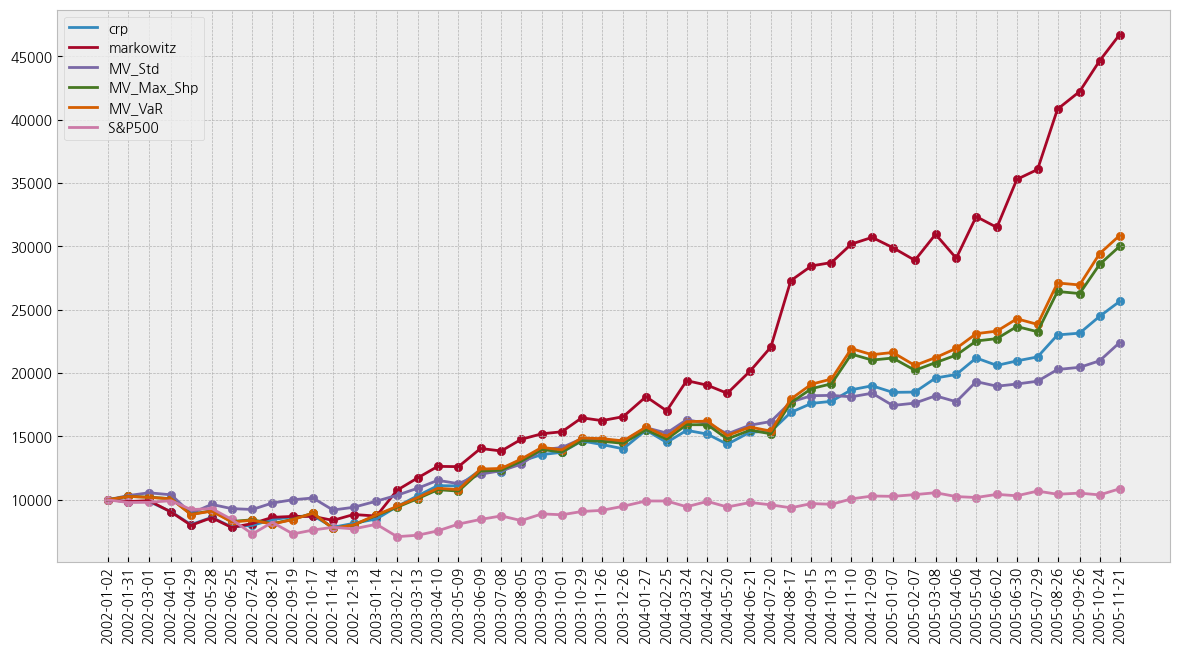

In [199]:
plt.figure(figsize=(12, 6))
plt.plot(perf_df)
plt.tight_layout()
plt.scatter(perf_df.index, perf_df['crp'])
plt.scatter(perf_df.index, perf_df['markowitz'])
plt.scatter(perf_df.index, perf_df['MV_Std'])
plt.scatter(perf_df.index, perf_df['MV_Max_Shp'])
plt.scatter(perf_df.index, perf_df['MV_VaR'])
plt.scatter(perf_df.index, perf_df['S&P500'])
plt.xticks(perf_df.index, rotation=90)
plt.legend(perf_df)